In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time
from tqdm.auto import tqdm
from PIL import Image
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import ParameterGrid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim, nn
from efficientnet_pytorch import EfficientNet

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 전처리 설정
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(4885) # Seed 고정

# 테스트 진행

In [4]:
cd /workspace/mnt2/data/tomato_except3/crop/TestDataSet/

/workspace/mnt2/data/tomato_except3/crop/TestDataSet


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


cd /workspace/mnt/data/ljh/농업 지식베이스/farm_data/

In [5]:
# 사용자 정의 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['healthy', 'PowderyMildew', 'GrayMold',\
                        'YellowLeafCurlVirus', 'LeafMold', 'LateBlight']
        self.img_paths = []
        valid_extensions = ('.jpg', '.jpeg', '.png')
        for dirpath, dirnames, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.lower().endswith(valid_extensions):
                    self.img_paths.append(os.path.join(dirpath, filename))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.get_label(img_path)
        return image, label, img_path  # img_path를 추가

    def get_label(self, img_path):
        if '0_healthy' in img_path:
            return self.classes.index('healthy')
        elif '1_PowderyMildew' in img_path:
            return self.classes.index('PowderyMildew')
        elif '2_GrayMold' in img_path:
            return self.classes.index('GrayMold')
        elif '3_YellowLeafCurlVirus' in img_path:
            return self.classes.index('YellowLeafCurlVirus')        
        elif '4_LeafMold' in img_path:
            return self.classes.index('LeafMold')
        elif '5_LateBlight' in img_path:
            return self.classes.index('LateBlight')  

In [6]:
# 테스트 데이터 
test_dirs = ["./0_healthy/",
            "./1_PowderyMildew/",
            "./2_GrayMold/",
            "./3_YellowLeafCurlVirus/",
            "./4_LeafMold/",
            "./5_LateBlight/",
           ]

test_datasets = [CustomImageDataset(test_dir, transform=transform_test) for test_dir in test_dirs]
test_dataset = torch.utils.data.ConcatDataset(test_datasets)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
# 최적의 모델 불러오기
model = EfficientNet.from_name('efficientnet-b0')

# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 분류할 클래스 수 변경
num_classes = 6
model._fc = torch.nn.Linear(model._fc.in_features, num_classes)

In [8]:
# 초기화
label_counts = {class_name: 0 for class_name in test_dataset.datasets[0].classes}

# test_dataset에서 반환되는 값의 수에 따라 변경해야 합니다.
for data in test_dataset:
    image, label = data[:2]  # 처음 두 값만 가져옴
    class_name = test_dataset.datasets[0].classes[label]
    label_counts[class_name] += 1

# 결과 출력
for disease, count in label_counts.items():
    print(f"{disease}: {count}개")

healthy: 2459개
PowderyMildew: 1470개
GrayMold: 1145개
YellowLeafCurlVirus: 137개
LeafMold: 109개
LateBlight: 31개


In [9]:
# sample_dataset = CustomImageDataset(root_dir="./some_directory", transform=None)
# print(sample_dataset[0][-1])  # 첫 번째 아이템의 img_path 출력

In [10]:
# 체크포인트 로드
model.load_state_dict(torch.load('/workspace/mnt2/data/tomato_except3/origin/resize/augmentation적용X/best_lr0.0001_batch64_optAdam_alpha0.25_gamma2.0.pth'))

<All keys matched successfully>

In [11]:
# model.load_state_dict(torch.load('/workspace/src/tomato_code/EfficientNet/result/best_model_loss_lr0.0001_batch32_optAdam.pth'))
model = model.to(device)

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터셋 평가
correct = 0
total = 0

class_correct = defaultdict(int)  # 클래스별로 올바르게 분류된 수를 저장
class_total = defaultdict(int)    # 각 클래스별 전체 샘플 수를 저장

all_labels = []
all_predicted = []
all_outputs = []

wrong_labels = []
wrong_predictions = []
wrong_images = []
wrong_image_paths = []

with torch.no_grad():  # gradient 계산 비활성화
    for images, labels, paths in test_loader:
        # print(paths)
        # break # 첫번째 배치 체크 디버깅
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        #재현율, F1, ROC커브
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())
        
        # 정확도 계산
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            label_idx = label.item()
            # Handle the case for batch size 1
            if len(labels) == 1:
                correct_pred = c.item()
            else:
                correct_pred = c[i].item()
            
            class_correct[label_idx] += correct_pred
            class_total[label_idx] += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        wrong_indices = (predicted != labels).nonzero(as_tuple=True)
        if wrong_indices[0].shape[0] > 0:  # 잘못 예측된 것이 하나 이상 있다면
            wrong_labels.extend(labels[wrong_indices].cpu().numpy())
            wrong_predictions.extend(predicted[wrong_indices].cpu().numpy())
            wrong_images.extend(images[wrong_indices].cpu().numpy())
            wrong_image_paths.extend([paths[i] for i in wrong_indices[0].cpu()])  # 이미지 경로 추가

test_acc = correct / total

In [12]:
print(f'정확도: {test_acc * 100:.2f}%')

# 재현율, F1 스코어 계산
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')
print(f'재현율: {recall:.2f}')
print(f'F1 스코어: {f1:.2f}')

정확도: 93.63%
재현율: 0.83
F1 스코어: 0.83


In [13]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict
# from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve

# # 체크포인트 로드
# model.load_state_dict(torch.load('/workspace/mnt/src/tomato_code/EfficientNet/result/earlystrop10/best_lr0.0001_batch128_optAdam.pth'))
# # model.load_state_dict(torch.load('/workspace/src/tomato_code/EfficientNet/result/best_model_loss_lr0.0001_batch32_optAdam.pth'))
# model = model.to(device)

# # 모델을 평가 모드로 설정
# model.eval()

# # 테스트 데이터셋 평가
# correct = 0
# total = 0

# class_correct = defaultdict(int)  # 클래스별로 올바르게 분류된 수를 저장
# class_total = defaultdict(int)    # 각 클래스별 전체 샘플 수를 저장

# all_labels = []
# all_predicted = []
# all_outputs = []

# wrong_labels = []
# wrong_predictions = []
# wrong_images = []
# wrong_image_paths = []

# with torch.no_grad():  # gradient 계산 비활성화
#     for images, labels, paths in test_loader:
#         # print(paths)
#         # break # 첫번째 배치 체크 디버깅
        
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)

#         #재현율, F1, ROC커브
#         all_labels.extend(labels.cpu().numpy())
#         all_predicted.extend(predicted.cpu().numpy())
#         all_outputs.extend(outputs.cpu().numpy())
        
#         # 정확도 계산
#         c = (predicted == labels).squeeze()
#         for i, label in enumerate(labels):
#             class_correct[label.item()] += c[i].item()
#             class_total[label.item()] += 1
        
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         wrong_indices = (predicted != labels).nonzero(as_tuple=True)
#         if wrong_indices[0].shape[0] > 0:  # 잘못 예측된 것이 하나 이상 있다면
#             wrong_labels.extend(labels[wrong_indices].cpu().numpy())
#             wrong_predictions.extend(predicted[wrong_indices].cpu().numpy())
#             wrong_images.extend(images[wrong_indices].cpu().numpy())
#             wrong_image_paths.extend([paths[i] for i in wrong_indices[0].cpu()])  # 이미지 경로 추가

# test_acc = correct / total
# print(f'테스트 정확도: {test_acc * 100:.2f}%')

# # 재현율, F1 스코어 계산
# recall = recall_score(all_labels, all_predicted, average='macro')
# f1 = f1_score(all_labels, all_predicted, average='macro')
# print(f'재현율: {recall:.2f}')
# print(f'F1 스코어: {f1:.2f}')

In [14]:
from sklearn.metrics import confusion_matrix
# 오차행렬 계산
cm = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2388   45    2   23    1    0]
 [  53 1405    4    3    5    0]
 [  39   91  969   42    4    0]
 [   0    2    0  135    0    0]
 [   1    0    4    0  104    0]
 [   2    2    9    4    5    9]]


In [15]:
# 클래스별 정확도 출력
for i in range(len(test_dataset.datasets[0].classes)):
    class_name = test_dataset.datasets[0].classes[i]
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'정확도 of {class_name}: {accuracy:.2f}%')

정확도 of healthy: 97.11%
정확도 of PowderyMildew: 95.58%
정확도 of GrayMold: 84.63%
정확도 of YellowLeafCurlVirus: 98.54%
정확도 of LeafMold: 95.41%
정확도 of LateBlight: 29.03%


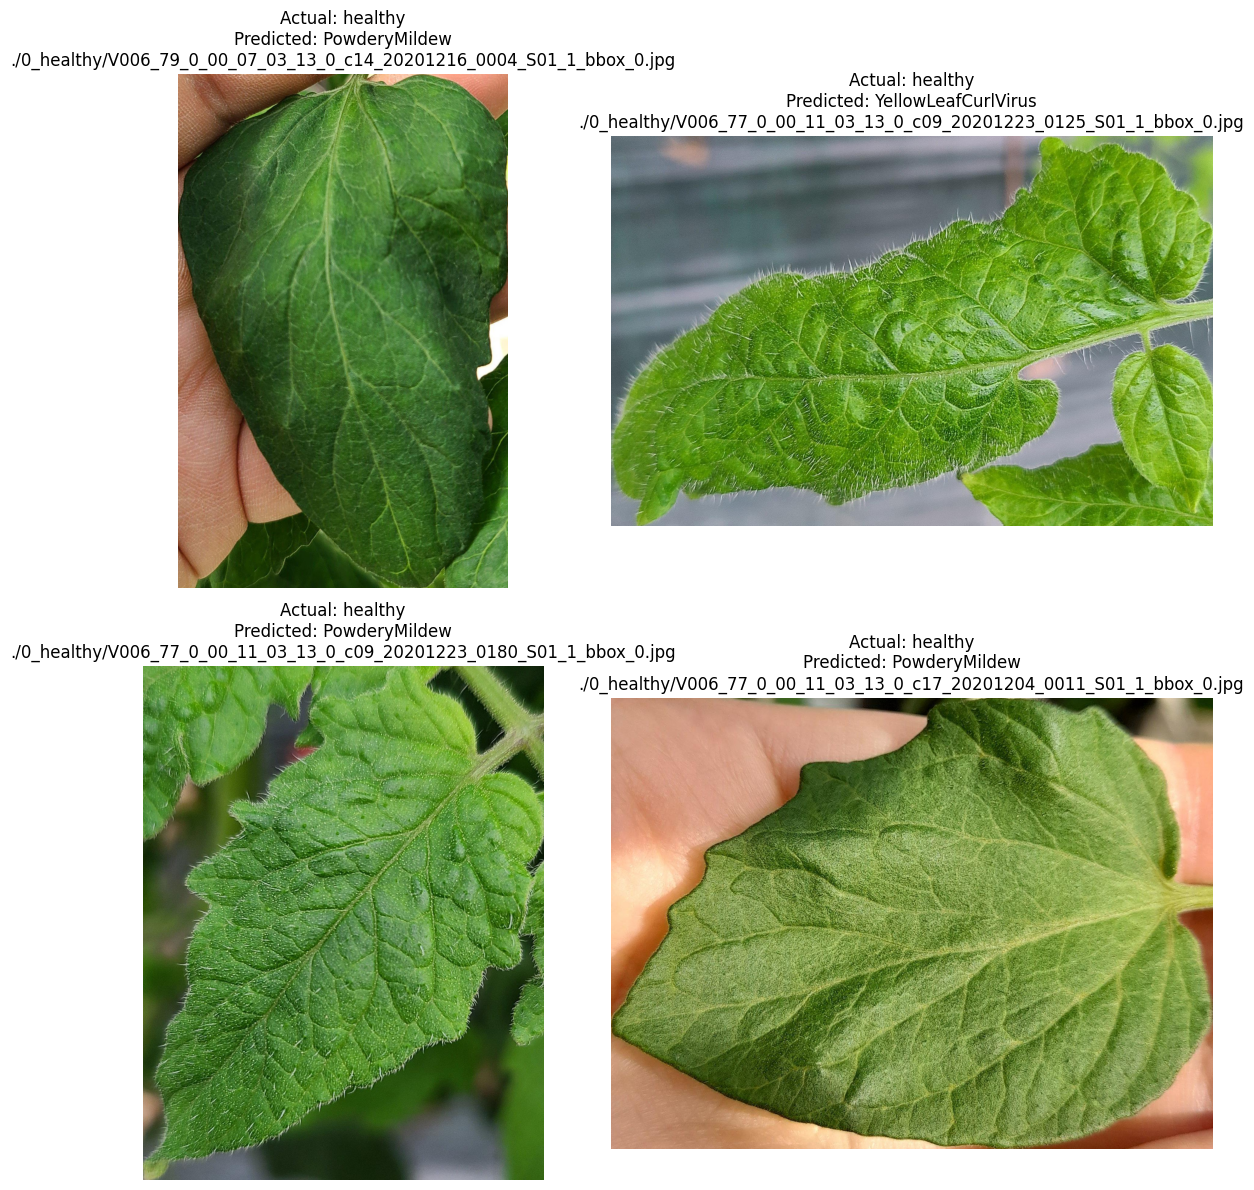

In [16]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import os

# LeafMold에 대한 틀린 예측 찾기
LeafMold_class_index = test_dataset.datasets[0].classes.index('healthy')

# LeafMold에 대한 틀린 예측 결과 저장
leaf_mold_wrong_images = []

for i in range(len(wrong_labels)):
    if wrong_labels[i] == LeafMold_class_index:  # 틀린 라벨 중 LeafMold에 해당하는 것만
        leaf_mold_wrong_images.append((wrong_labels[i], wrong_predictions[i], wrong_image_paths[i]))

# 랜덤하게 4개 선택
random_selection = random.sample(leaf_mold_wrong_images, min(4, len(leaf_mold_wrong_images)))

# 2x2 형태로 이미지 출력
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i in range(len(random_selection)):
    label, pred, img_path = random_selection[i]
    original_image = Image.open(img_path).convert('RGB')
    
    axes[i].imshow(np.array(original_image))
    axes[i].set_title(f"Actual: {test_dataset.datasets[0].classes[label]}\nPredicted: {test_dataset.datasets[0].classes[pred]}\n{img_path}")  # 이미지 경로 추가
    axes[i].axis('off')

plt.tight_layout()
plt.show()

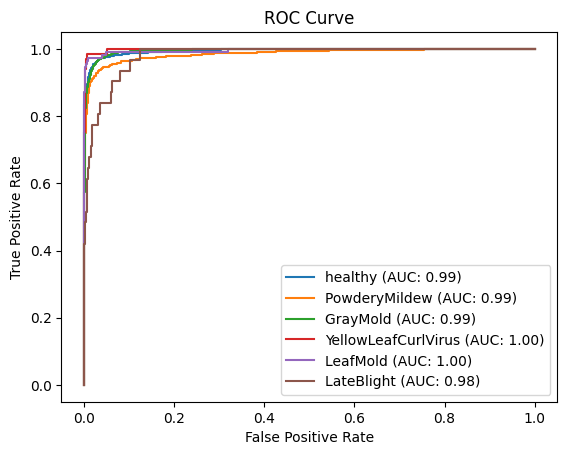

In [17]:
# ROC 커브 및 AUC 계산 (멀티 클래스의 경우 One-vs-Rest 방식 사용)
n_classes = len(test_dataset.datasets[0].classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

all_labels_onehot = np.eye(n_classes)[all_labels]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], np.array(all_outputs)[:, i])
    roc_auc[i] = roc_auc_score(all_labels_onehot[:, i], np.array(all_outputs)[:, i])


# 모든 클래스에 대한 ROC 커브 플로팅
for i in range(n_classes):
    class_name = test_dataset.datasets[0].classes[i]
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC: {roc_auc[i]:.2f})')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

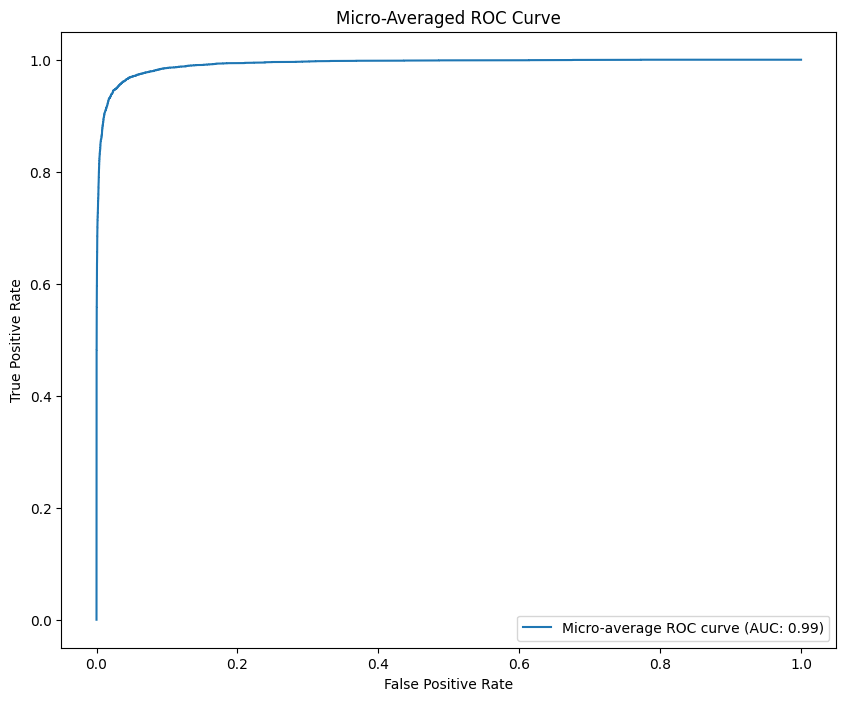

In [18]:
# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_onehot.ravel(), np.array(all_outputs).ravel())
roc_auc["micro"] = roc_auc_score(all_labels_onehot, np.array(all_outputs), average="micro")

# Plot the micro-averaged ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC: {roc_auc["micro"]:.2f})')

# Plot details
plt.title('Micro-Averaged ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()